In [1]:
from keras.optimizers import *
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.utils import np_utils

import os,sys
import numpy as np
import pandas as pd
import cv2,time,glob,math
import matplotlib.pyplot as plt # plt 用于显示图片
from tqdm import tqdm #进度条

Using TensorFlow backend.


In [2]:
#设置一些基本参数
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test2'
nb_train_samples = sum([len(x) for _, _, x in os.walk(train_dir)])
nb_valid_samples = sum([len(x) for _, _, x in os.walk(valid_dir)])
nb_test_samples = sum([len(x) for _, _, x in os.walk(test_dir)])
nb_categories = 10
epochs = 5
labels = [" normal driving","texting - right","talking on the phone - right","texting - left",
          "talking on the phone - left","operating the radio",
          "drinking"," reaching behind","hair and makeup","talking to passenger"]

In [3]:
from keras import backend as K
K.clear_session()

In [4]:
#set training parameters
model_name = 'VGG16'
fine_tune_layer = 15
optimizer = 'Adam'
learning_rate = 1e-3
augmentation = 'yes'
valid_set = 'p056_p066'
batch_size = 64
img_width, img_height = 224, 224

In [5]:
# 利用Keras的ImageDataGenerator对图片进行预处理
def preprocess_input(x):
    x = x[:, :, [2,1,0]]
    x = x - [103.939, 116.779, 123.68]
    return x 
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=15) 
#考虑到体型、姿势略有不同，设置少许的旋转、放大缩小和平移。不做翻转） 

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
#验证集和测试集无须进行上述处理，保留原样

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(img_width,img_height),  
        shuffle=True,
        batch_size=batch_size,
        class_mode='categorical')  


validation_generator = datagen.flow_from_directory(
        valid_dir,
        target_size=(img_width,img_height),
        shuffle=True,
        batch_size=batch_size,
        class_mode='categorical')

test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(img_width,img_height),
        shuffle=False,
        batch_size=batch_size,
        class_mode='categorical')

Found 20596 images belonging to 10 classes.
Found 1828 images belonging to 10 classes.
Found 79726 images belonging to 1 classes.


In [6]:
from keras import backend as K
K.clear_session()

inputs = Input(shape=(img_width, img_height, 3))
base_model = VGG16(input_tensor=inputs, weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs, x)

print 'total layer count: ', len(base_model.layers),
print '| fine tune layer: ', fine_tune_layer


total layer count:  19 | fine tune layer:  15


In [7]:
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#训练top
model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples//batch_size,epochs=1,
                   validation_data=validation_generator,
                   validation_steps=nb_valid_samples//batch_size)
model.save_weights('models/VGG16toptrained.h5')

Epoch 1/1
321/321 [==============================] - 346s - loss: 7.3200 - acc: 0.2054 - val_loss: 2.6230 - val_acc: 0.3376


In [9]:
#Fine tune 模型
#lock VGG16 layers, execpt the last CNN block. 
for layer in model.layers:
    layer.trainable = True
    
for layer in model.layers[:15]:
    layer.trainable = False

#recomplie the optimizer, use SGD at a low learning rate 
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.load_weights('models/VGG16fine_tuned.h5')

In [10]:
#训练fine-tune模型
result = model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples//batch_size,epochs=10,
                   validation_data=validation_generator,
                   validation_steps=nb_valid_samples//batch_size)
model.save_weights('models/VGG16fine_tuned.h5')

Epoch 1/10
321/321 [==============================] - 382s - loss: 1.1206 - acc: 0.6416 - val_loss: 0.5867 - val_acc: 0.8430
Epoch 2/10
321/321 [==============================] - 372s - loss: 0.4516 - acc: 0.8556 - val_loss: 0.4774 - val_acc: 0.8702
Epoch 3/10
321/321 [==============================] - 373s - loss: 0.3052 - acc: 0.9055 - val_loss: 0.4174 - val_acc: 0.8781
Epoch 4/10
321/321 [==============================] - 371s - loss: 0.2293 - acc: 0.9274 - val_loss: 0.3745 - val_acc: 0.8951
Epoch 5/10
321/321 [==============================] - 371s - loss: 0.1898 - acc: 0.9425 - val_loss: 0.3813 - val_acc: 0.8900
Epoch 6/10
321/321 [==============================] - 371s - loss: 0.1641 - acc: 0.9492 - val_loss: 0.4245 - val_acc: 0.8770
Epoch 7/10
321/321 [==============================] - 369s - loss: 0.1375 - acc: 0.9576 - val_loss: 0.3903 - val_acc: 0.8821
Epoch 8/10
321/321 [==============================] - 368s - loss: 0.1245 - acc: 0.9625 - val_loss: 0.3630 - val_acc: 0.8889


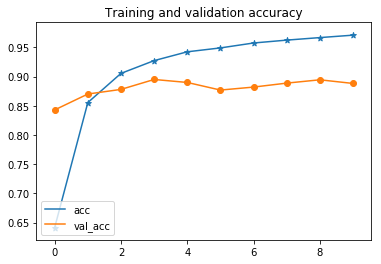

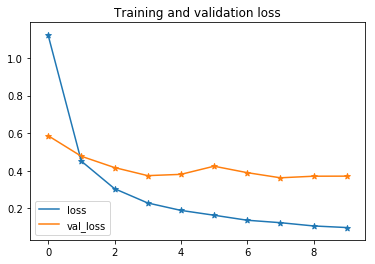

In [11]:
# 画图
def draw_gragh(result):
    plt.figure
    plt.plot(result.epoch,result.history['acc'],label="acc")
    plt.plot(result.epoch,result.history['val_acc'],label="val_acc")
    plt.scatter(result.epoch,result.history['acc'],marker='*')
    plt.scatter(result.epoch,result.history['val_acc'])
    plt.title('Training and validation accuracy')
    plt.legend(loc='lower left')
    plt.show()
    plt.figure
    plt.plot(result.epoch,result.history['loss'],label="loss")
    plt.plot(result.epoch,result.history['val_loss'],label="val_loss")
    plt.scatter(result.epoch,result.history['loss'],marker='*')
    plt.scatter(result.epoch,result.history['val_loss'],marker='*')
    plt.title('Training and validation loss')
    plt.legend(loc='lower left')
    plt.show()
draw_gragh(result)

In [12]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show):
    test_dir = 'test2/test/test'
    image_files = glob.glob(os.path.join(test_dir,"*"))
    
    plt.figure(figsize=(12, 14))
    for i in tqdm(range(16)):
        plt.subplot(4, 4, i+1)
        img = cv2.imread(image_files[np.random.randint(len(image_files))])
        img = cv2.resize(img, (img_width, img_height))
        x = img.copy()
        x.astype(np.float32)
        out, predictions = model_show.predict(np.expand_dims(x, axis=0))
        predictions = predictions[0]
        out = out[0]
        
        pred_class = np.argmax(predictions)
        prob = predictions[pred_class]

        plt.title('c%d |%s| %.2f%%' % (pred_class , labels[pred_class], prob*100))
    
        cam = prob * np.matmul(out, weights_show)
        cam = cam[:,:,pred_class]
        cam -= cam.min()
        cam /= cam.max()
        cam -= 0.2
        cam /= 0.8

        cam = cv2.resize(cam, (img_width, img_height))
        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam <= 0.2)] = 0

        out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
        plt.axis('off')
        plt.imshow(out[:,:,::-1])
print("done")

done


  0%|          | 0/16 [00:00<?, ?it/s]

layer_output Tensor("block5_pool/MaxPool:0", shape=(?, 7, 7, 512), dtype=float32)
weights shape (512, 10)


100%|██████████| 16/16 [00:02<00:00,  7.11it/s]


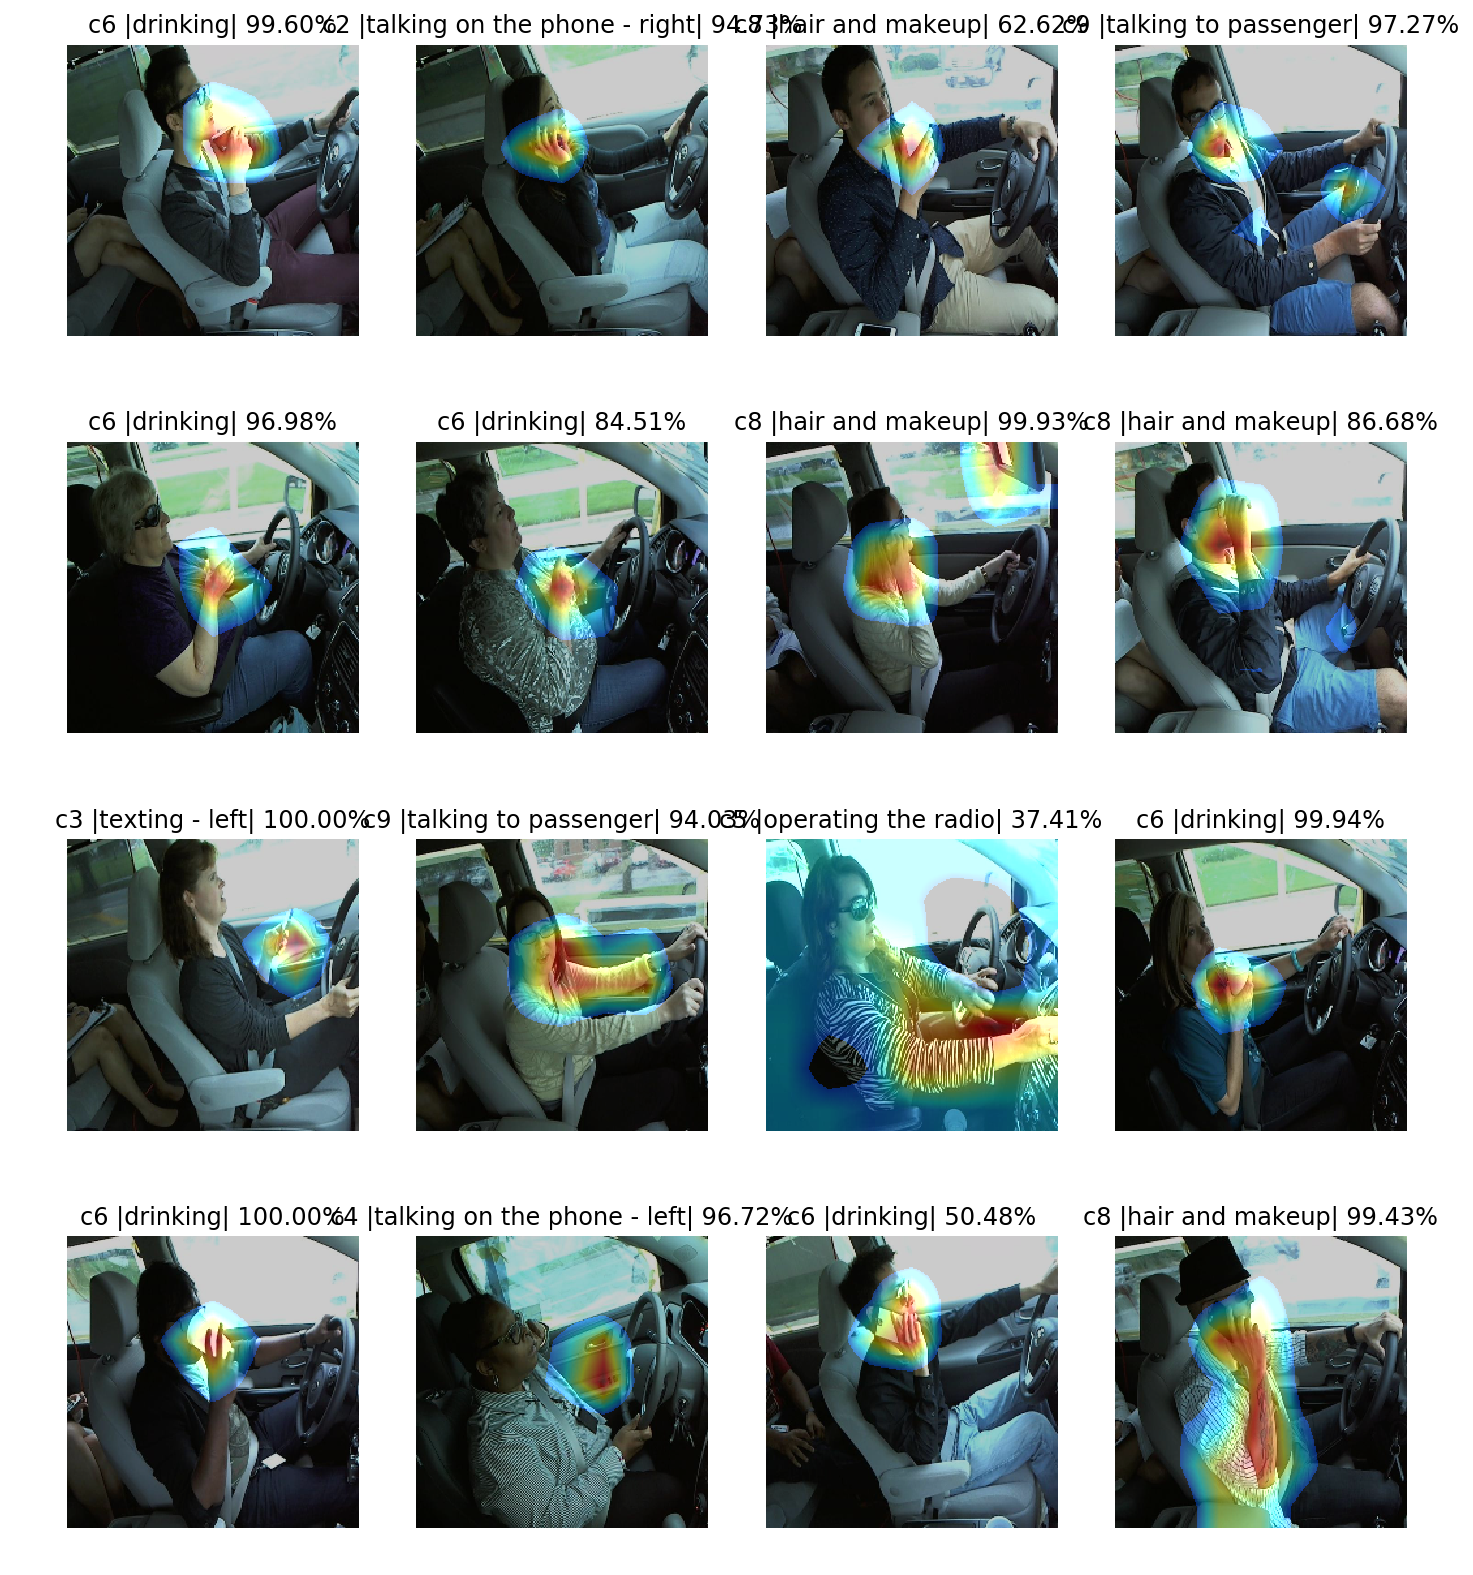

In [13]:
weights = model.layers[21].get_weights()[0]
layer_output = model.layers[18].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))
show_heatmap_image(model2, weights)